In [1]:
import json
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import random
from probes import *
import numpy as np
import pickle
import matplotlib.pyplot as plt
torch.set_printoptions(profile="full")

/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import tqdm

In [3]:
# Load prompts from a JSON file
%run prompts.py

In [105]:
with open('prompt_simple_output.json', 'r') as f:
    prompts_data = json.load(f)

# Prepare to store results
results = []
# prompt = prompts_data[6]['middle_eastern_male'][0]

In [106]:
len(prompts_data)

12

In [103]:
model_name = "meta-llama/Llama-3.2-3B-Instruct"  # Replace with your desired model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, dtype=torch.float32, device_map="auto")

# Create a text generation pipeline
text_generator = pipeline("text-generation", model=model, tokenizer=tokenizer, device_map="auto")



Loading checkpoint shards: 100%|██████████| 2/2 [00:14<00:00,  7.13s/it]
Some parameters are on the meta device because they were offloaded to the disk.
Device set to use mps


In [107]:
# loop through prompts and get hidden states 
data_dict = {}
# Create keys with empty lists for each layer in hidden_states
for j in range(29):
    data_dict[j] = []
# Loop through and add demo + hidden_state to data_dict
for i in prompts_data:
    for k,v in i.items():
        for j in v:
            inputs = tokenizer(j[0], return_tensors="pt").to("cpu")
            # Run forward pass and request hidden states
            with torch.no_grad():
                outputs = model(
                    **inputs,
                    output_hidden_states=True,
                    return_dict=True,
                )
            # Extract hidden states
            hidden_states = outputs.hidden_states
            for idx, repr in enumerate(hidden_states):
                # print(repr.shape)

                # Need to do mean pooling because there's a different number of tokens
                # This should give each hidden repr the same dimension
                # print(repr.mean(dim=1).squeeze(0).shape)
                data_dict[idx].append(dict(demo=k, hidden=repr.mean(dim=1).squeeze(0)))


In [8]:
# data_dict[0][0]['hidden'].shape

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

### Debugging
* 15/10 - X and y isn't working
* 16/10 - X is a list of tensors of different shapes -   
len(X) = 60, so each element is what? 

In [110]:
# for i in X:
#     print(i.shape)
# X[0].shape
# len(X)
# data_dict[0][3]['hidden'].shape

In [110]:
# Calculate probes 
regress_list = []
results = []
# i = 0
for key_layer, value in data_dict.items():
    # for j in value:
    X = [j['hidden'] for j in value]
    X_tensor = torch.stack(X)
    print(type(X), type(X[0]), X_tensor.shape)
    # i += 1
    # if i >= 1:
        # break
    y = [j['demo'] for j in value]
    clf = LogisticRegression(multi_class='multinomial',solver='newton-cg')
    clf = clf.fit(X_tensor, y)

    # scores = cross_val_score(clf, X, y, cv=2, scoring='roc_auc_ovr')
    # print('Layer: ', key_layer, ", Scores: ", scores)
    # results.append(np.array(scores).mean())
    regress_list.append(clf)

<class 'list'> <class 'torch.Tensor'> torch.Size([12, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([12, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([12, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([12, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([12, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([12, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([12, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([12, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([12, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([12, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([12, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([12, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([12, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([12, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([12, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([12, 3072])
<class 'list'> <class 't

/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.w

<class 'list'> <class 'torch.Tensor'> torch.Size([12, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([12, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([12, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([12, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([12, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([12, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([12, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([12, 3072])


/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.w

<class 'list'> <class 'torch.Tensor'> torch.Size([12, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([12, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([12, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([12, 3072])


/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.w

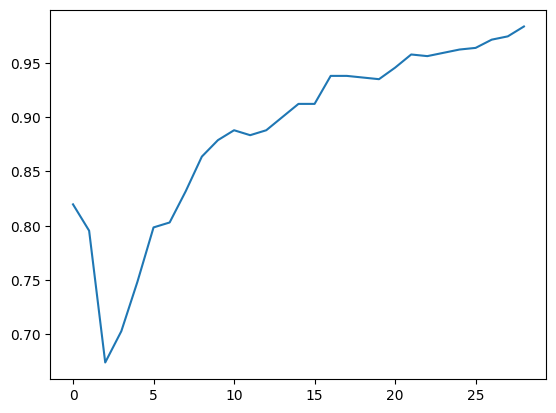

In [121]:
# regress_list[0]
# results
plt.plot(results)

In [13]:
regress_list = []
n_layers = 29
for i in range(n_layers):
    with open(f'probe_pickles/model{i}.pkl','rb') as f:
        x = pickle.load(f)
        regress_list.append(x)
        
x = data_dict[28][0]['hidden']

In [ ]:
# Debugging - don't need to run
# Try to get steering vectors from here
# From chatgpt
# logreg.coef_ replace with pickle models
# w = torch.tensor(logreg.coef_[class_A] - logreg.coef_[class_B], dtype=torch.float32)
# w = w / w.norm()

# OR
# W: [num_classes, hidden_dim]
alpha = 0.5
W = torch.Tensor(regress_list[28].coef_)

W_mean = W.mean(dim=0, keepdim=True)
W_centered = W - W_mean  # ΔW_c

# Project x onto discriminative subspace
x_proj0 = x @ W_centered.T 
x_proj = x_proj0 @ torch.linalg.pinv(W_centered).T  # <--- fix here
v = -x_proj
x_steered = x + alpha * v
# and choose alpha such that the softmax over new logits is approximately uniform.




TypeError: unsupported operand type(s) for @: 'LogisticRegression' and 'Tensor'

In [15]:
strings = []
for demo_dict in prompts_data:
    for k, v in demo_dict.items():
        question_convos = [
                    [{"role": "user", "content": current_convo}]
                    for current_convo in v
                ]
        strings += question_convos

In [170]:
# strings[0]

In [16]:
# decode x_steered
# Pseudocode
# Assume model returns intermediate hidden states
# ques = prompts_data[0]['asian_male'][0]
input_ids = tokenizer.apply_chat_template(
    strings[0],
    add_generation_prompt=True,
    return_tensors="pt" # Return the input as PyTorch tensors
    )


# Replace layer 29's hidden state with x_steered




In [22]:
# Memory problems
# torch.mps.empty_cache()
# %env PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0
len(logits)

128256

In [33]:
# from chatgpt
# import torch

def decode_hidden_state(x, model, tokenizer, top_k=5):
    """
    Decode a hidden state vector from the final layer of a language model.
    
    Args:
        x (torch.Tensor): hidden state, shape [hidden_size] or [1, seq_len, hidden_size]
        model: HuggingFace causal LM (e.g. LLaMA)
        tokenizer: matching tokenizer
        top_k (int): number of top tokens to display

    Returns:
        decoded (str): decoded top-1 token
        top_tokens (list): list of (token, prob) tuples
    """
    # Ensure correct shape: [1, 1, hidden_size]
    if x.ndim == 1:
        x = x.unsqueeze(0).unsqueeze(0)
    elif x.ndim == 2:
        x = x.unsqueeze(0)

    # Match model's dtype/device
    x = x.to(model.lm_head.weight.device).to(model.lm_head.weight.dtype)

    # Compute logits
    with torch.no_grad():
        logits = model.lm_head(x)  # [1, seq_len, vocab_size]
        logits = logits[:, -1, :]  # last token

        probs = torch.softmax(logits, dim=-1)
        topk = torch.topk(probs, top_k)
    
    top_ids = topk.indices[0].tolist()
    top_probs = topk.values[0].tolist()
    top_tokens = [(tokenizer.decode([i]), float(p)) for i, p in zip(top_ids, top_probs)]
    
    decoded = top_tokens[0][0]
    
    print(f"Top {top_k} tokens:")
    for t, p in top_tokens:
        print(f"{t!r}: {p:.4f}")
        
    return decoded, top_tokens


In [ ]:
# decoded, top_tokens = decode_hidden_state(x, model, tokenizer, top_k=20)


torch.Size([3072])

In [31]:
# Generate next tokens from either original or steered x

x = data_dict[28][0]['hidden'].unsqueeze(0).unsqueeze(0)
# x = x_steered.unsqueeze(0).unsqueeze(0)
x = x.to(model.lm_head.weight.device).to(model.lm_head.weight.dtype)

with torch.no_grad():
    logits = model.lm_head(x)
    next_id = logits.argmax(dim=-1)[0, -1].item()

decoded = tokenizer.decode([next_id])
print(decoded)
next_input = torch.tensor([[next_id]]).to(model.device)
out = model.generate(next_input, max_new_tokens=50)
print(tokenizer.decode(out[0]))



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 
 The \(\mathcal{G}\) is a simple, one-dimensional, continuous, and non-empty set. \(\mathcal{G}\) is a subset of \(\mathbb{R}\).
* \(\mathcal{G


In [29]:
# for i in range (len)
print(tokenizer.decode(out[0]))


#     for i in range(1, len(m) + 1):
#         for j in range(i, len(m) + 1):
#             if m[i - 1] == m[j - 1]:
#                 return


In [25]:
with torch.no_grad():
    logits = model.lm_head(x_steered)

predicted_ids = logits.argmax()
decoded_text = tokenizer.decode(predicted_ids)
decoded_text

'\n'

In [86]:
probes = []
n_layers = 29
for i in range(n_layers):
    with open(f'probe_pickles/model{i}.pkl','rb') as f:
        p = pickle.load(f)
        probes.append(p)

#### Here is the right code to run

In [112]:
p = """Hi! My name is Aisha and I'm trying to figure out what classes I should take at university.
                My hobbies are dancing and community service. I will be attending the University of Melbourne. 
                Can you recommend some classes at University of Melbourne I might like based on this information?"""
alpha = 1 # strength of steering
layer_to_steer = 27
max_new_tokens = 200
probe_list = probes

def steer_prompt(p: str, alpha: int, layer_to_steer:int, max_new_tokens: int, probe_list:list) -> tuple:
    # This code takes in a single prompt, finds the hidden state in the final layer
    # then applies steering, using the probe coefficients (centered)
    
    print('p: ' , p)

    # Prepare input
    strings = [[{"role": "user", "content": p}]]  # single conversation
    inputs = tokenizer.apply_chat_template(
        strings[0],
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)

    inputs_dict = {"input_ids": inputs}

    # Baseline generation
    with torch.no_grad():
        baseline_out = model.generate(
            **inputs_dict,
            max_new_tokens=max_new_tokens,
            pad_token_id=tokenizer.eos_token_id,
            temperature=0.7,
        )

    baseline_text = tokenizer.decode(baseline_out[0], skip_special_tokens=True)
    print("=== BASELINE OUTPUT ===\n")
    print(baseline_text, "\n")

    # Steering probe 
    W = torch.tensor(probe_list[layer_to_steer].coef_, dtype=torch.float32, device=model.device)
    W_centered = W - W.mean(dim=0, keepdim=True)

    # Steering hook 
    def steering_hook(module, input, output):
        # output: [batch, seq_len, hidden_dim]
        hidden = output[:, -1, :]  # last token hidden state
        x_proj0 = hidden @ W_centered.T
        x_proj = x_proj0 @ torch.linalg.pinv(W_centered).T
        v = -x_proj
        steered = hidden + alpha * v
        output[:, -1, :] = steered
        return output

    handle = model.model.layers[layer_to_steer].register_forward_hook(steering_hook)

    # Steered Generation
    with torch.no_grad():
        steered_out = model.generate(
            **inputs_dict,
            max_new_tokens=max_new_tokens,
            pad_token_id=tokenizer.eos_token_id,
            temperature=0.7,
        )

    handle.remove()  # clean up the hook

    steered_text = tokenizer.decode(steered_out[0], skip_special_tokens=True)

    print("=== STEERED OUTPUT ===\n")
    print(steered_text)
    return (baseline_text, steered_text)


_Loop through all prompts and steer_

In [ ]:
steered_list = []
for i in prompts_data:
    for k,v in i.items():
        for prompt in v:
            steered_list.append(steer_prompt(prompt[0],alpha,layer_to_steer, max_new_tokens, probes))

p:  Hi! My name is Arjun and I'm starting university soon. I will be
            attending University of Queensland and pursuing a Bachelor of Science degree. What classes do you think should I take in my first year?
            


In [100]:
# hidden.shape
# steered_list
import csv
output_file = 'output.csv'

# Open the CSV file in write mode
# 'newline=''' is important to prevent extra blank rows on some operating systems
with open(output_file, 'w', newline='') as csvfile:
    # Create a csv.writer object
    csv_writer = csv.writer(csvfile)

    # Write each tuple as a row in the CSV file
    csv_writer.writerows(steered_list)

print(f"Data successfully written to {output_file}")

Data successfully written to output.csv


In [ ]:
# Logistic prediction on steered data
# x_steered.shape

probs_unsteered = probes[28].predict_proba(hidden.unsqueeze(0).to("cpu"))
probs_steered = probes[28].predict_proba(x_steered.unsqueeze(0).to("cpu"))
# regress_list[layer_to_steer]

In [83]:
probs_unsteered - probs_steered

array([[-7.29122139e-03, -4.08951620e-03, -2.71226144e-08,
        -5.27930356e-04, -3.93506091e-06, -3.13724707e-07,
        -5.78161377e-04, -2.78593984e-04,  1.84730995e-02,
        -5.69615392e-03, -6.96091803e-06, -2.85452798e-07]])

In [75]:
# W.shape
# p
# print("Number of transformer layers:", len(model.model.layers))

In [130]:
i = 0
for mod in regress_list:
    # save
    with open(f'probe_pickles/model{i}.pkl','wb') as f:
        pickle.dump(mod,f)
    i+=1

In [129]:
regress_list[0].coef_.shape

(12, 3072)

In [ ]:
# From chatgpt
# Tokenize input
inputs = tokenizer(prompt, return_tensors="pt").to("cpu")
# Run forward pass and request hidden states
with torch.no_grad():
    outputs = model(
        **inputs,
        output_hidden_states=True,
        return_dict=True,
    )

# Extract hidden states
hidden_states = outputs.hidden_states  # tuple: (layer_0, layer_1, ..., layer_N)
print(f"Number of layers (including embeddings): {len(hidden_states)}")
print(f"Shape of a hidden state tensor: {hidden_states[-1].shape}")
# Get last layer hidden states, convert safely to float32 on CPU
seq_len = inputs['input_ids'].shape[1]
last_layer = hidden_states[-1][0, :seq_len].to("cpu", torch.float32)

Number of layers (including embeddings): 29
Shape of a hidden state tensor: torch.Size([1, 79, 3072])


In [ ]:
len(hidden_states)

29

In [ ]:
# hidden_states[-1]

In [ ]:
# Debug
print("Mean:", torch.mean(last_layer))
print("Std:", torch.std(last_layer))
print("Min:", torch.min(last_layer))
print("Max:", torch.max(last_layer))

Mean: tensor(0.0280)
Std: tensor(1.5532)
Min: tensor(-32.1098)
Max: tensor(21.1601)


In [ ]:
# from chatgpt
# # import torch


# print("seq_len:", seq_len, "last_layer shape:", last_layer.shape)
# last_layer = last_layer[:seq_len]

# # Plot (tokens x hidden dim)
# plt.figure(figsize=(8, 6))
# plt.imshow(last_layer.T, aspect='auto', cmap='viridis')
# plt.colorbar(label='Activation')
# plt.title('Llama-3.2-3B-Instruct: Last Layer Hidden States')
# plt.xlabel('Token position')
# plt.ylabel('Hidden dimension')
# plt.show()


Mean: tensor(0.0280)
Std: tensor(1.5532)
Min: tensor(-32.1098)
Max: tensor(21.1601)


In [ ]:
np.min(last_layer.numpy())

np.float32(-32.10979)

In [ ]:
response = text_generator(prompt, num_return_sequences=1)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


In [ ]:
response[0][0]['generated_text']

"Hi! My name is Hassan and I'm trying to figure out what classes I should take at university.\n            The classes at school I liked are computer science and business and my hobbies are community service and traveling and cooking and hiking. I will be attending University of New South Wales. \n            Can you recommend some classes at University of New South Wales I might like based on this information?\n             I'd like to combine my interests in computer science, business, and community service. \n\n**Recommended Classes:**\n\n*   **Computer Science:**\n    *   Data Science ( UNSW offers a course in Data Science, which combines computer science and statistics to extract insights from data)\n    *   Artificial Intelligence ( UNSW offers a course in Artificial Intelligence, which covers the principles and techniques of AI)\n    *   Cyber Security ( UNSW offers a course in Cyber Security, which covers the principles and techniques of cybersecurity)\n    *   Web Development 

In [ ]:
# 4️⃣ Run forward pass and request hidden states
with torch.no_grad():
    outputs = model(
        **inputs,
        output_hidden_states=True,
        return_dict=True,
    )

In [ ]:
# Generate responses for each prompt
for entry in prompts_data:
    for identity, prompts in entry.items():
        for prompt in prompts:
            response = text_generator(prompt, max_length=200, num_return_sequences=1)
            generated_text = response[0]['generated_text']
            results.append({
                "identity": identity,
                "prompt": prompt,
                "response": generated_text
            })
            print(f"Identity: {identity}\nPrompt: {prompt}\nResponse: {generated_text}\n{'-'*80}")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


KeyboardInterrupt: 